### Kayla Hoffman 
### Github Username: kaylah176
### USC ID: 5610 8598 16

### Homework 3 - Time Series Classification 
### Part 1 - Feature Creation / Extraction

In [15]:
# Import libraries 
import glob 
import os 
import numpy as np 
import pandas as pd 

from matplotlib import pyplot as plt
from scipy.stats import bootstrap

import warnings
warnings.filterwarnings("ignore")


a) Download the AReM data 

 b) The goal here is to keep datasets 1 and 2 in folders 'bending1' and 'bending2'. In addition, datasets 1, 2, and 3 are to be kept in other folders as test data and the rest of the datasets as training data. 

In [35]:
import os
import pandas as pd
import warnings

def data_split(folder_name, num_data_set, num_test_set):
    current_dir = os.getcwd()
    base_path = os.path.join(current_dir, 'AReM', folder_name)
    
    def read_csv(file_num):
        file_path = os.path.join(base_path, f'dataset{file_num}.csv')
        try:
            # Try reading the CSV with default settings
            return pd.read_csv(file_path, skiprows=4)
        except pd.errors.ParserError:
            try:
                # If that fails, try reading with more flexible parsing
                with warnings.catch_warnings():
                    warnings.simplefilter("ignore")
                    df = pd.read_csv(file_path, skiprows=4, error_bad_lines=False, warn_bad_lines=False)
                print(f"Note: Skipped some lines in {file_path}")
                return df
            except Exception as e:
                # If both methods fail, print an error message and return an empty DataFrame
                print(f"Error processing file {file_path}: {str(e)}")
                return pd.DataFrame()

    test_frame = pd.concat([df for df in (read_csv(i) for i in range(1, num_test_set + 1)) if not df.empty], ignore_index=True)
    train_frame = pd.concat([df for df in (read_csv(j) for j in range(num_test_set + 1, num_data_set + 1)) if not df.empty], ignore_index=True)
    
    return test_frame, train_frame


In [37]:
# Generate testing and training data from ARem folder
# Initialize list to store information
arem_testing = list()
arem_training = list()

# Deal with bending data first
bending = ["bending1", "bending2"]
arem_testing.append(data_split("bending1", 7, 2)[0])
arem_training.append(data_split("bending1", 7, 2)[1])
arem_testing.append(data_split("bending2", 6, 2)[0])
arem_training.append(data_split("bending2", 6, 2)[1])
    
# Deal with other data
other = ["cycling", "lying", "sitting", "standing", "walking"]
for folder in other:
    arem_testing.append(data_split(folder, 15, 3)[0])
    arem_training.append(data_split(folder, 15, 3)[1])
      
# Concatenate into testing and training dataframe
AREM_test = pd.concat(arem_testing, ignore_index=True)
AREM_train = pd.concat(arem_training, ignore_index=True)

Note: Skipped some lines in /Users/kaylahoffman/Desktop/AReM/cycling/dataset9.csv
Note: Skipped some lines in /Users/kaylahoffman/Desktop/AReM/cycling/dataset14.csv
Note: Skipped some lines in /Users/kaylahoffman/Desktop/AReM/cycling/dataset9.csv
Note: Skipped some lines in /Users/kaylahoffman/Desktop/AReM/cycling/dataset14.csv


In [38]:
# Check the dimensions
print("Testing set shape:", AREM_test.shape)
print("Training set shape:", AREM_train.shape)

Testing set shape: (9120, 7)
Training set shape: (33117, 7)


In [39]:
AREM_test.head()

,# Columns: time,avg_rss12,var_rss12,avg_rss13,var_rss13,avg_rss23,var_rss23
0,0,39.25,0.43,22.75,0.43,33.75,1.3
1,250,39.25,0.43,23.00,0.00,33.00,0.0
2,500,39.25,0.43,23.25,0.43,33.00,0.0
3,750,39.50,0.50,23.00,0.71,33.00,0.0
4,1000,39.50,0.50,24.00,0.00,33.00,0.0


In [40]:
AREM_train.head()

,# Columns: time,avg_rss12,var_rss12,avg_rss13,var_rss13,avg_rss23,var_rss23
0,0,42.00,0.71,21.25,0.43,30.00,0.00
1,250,41.50,0.50,20.25,1.48,31.25,1.09
2,500,41.50,0.50,14.25,1.92,33.00,0.00
3,750,40.75,0.83,15.75,0.43,33.00,0.00
4,1000,40.00,0.71,20.00,2.74,32.75,0.43


c) Feature Extraction 
Classification of time series data needs features extracted. In this problem we want to focus on time domain features.

i) According to this post ____ the following features can be used in time series classification. 
### Statistical Features 
1. Mean 
2. Standard deviation 
3. Skewness, Kurtosis 
4. Maximum and Minimum values 

In [41]:
def feature_extraction(folder_name, num_csv):
    current_dir = os.getcwd()
    base_path = os.path.join(current_dir, 'AReM', folder_name)
    
    extractions = []
    features = ['min', 'max', 'mean', '50%', 'std', '25%', '75%']
    series = ['avg_rss12', 'var_rss12', 'avg_rss13', 'var_rss13', 'avg_rss23', 'var_rss23']
    
    global instance_cnt
    
    for i in range(1, num_csv + 1):
        file_path = os.path.join(base_path, f"dataset{i}.csv")
        
        if not os.path.exists(file_path):
            print(f"File not found: {file_path}")
            continue
        
        try:
            df = pd.read_csv(file_path, skiprows=4)
            
            instance_features = [instance_cnt]
            for series_name in series:
                series_stats = df[series_name].describe()
                for feature in features:
                    instance_features.append(series_stats[feature])
            
            extractions.append(instance_features)
            instance_cnt += 1
        except Exception as e:
            print(f"Error processing file {file_path}: {str(e)}")
    
    return extractions


In [42]:
# Set serie names
series = ["avg_rss12", "var_rss12", "avg_rss13", "var_rss13", "avg_rss23", "var_rss23"]
series_formatname = [i for i in range(1, 7)]
# Set feature names to be extracted
features = ['min', 'max', 'mean', '50%', 'std', '25%', '75%']
features_formatname = ['min', 'max', 'mean', 'median', 'std dev', '1st quart', '3rd quart']

# Initialize counting and list to store information
instance_cnt = 1
extracted_features = list()

# Iterate through csv in bending1 folder
extracted_features.extend(feature_extraction("bending1", 7))
# Iterate through csv in bending1 folder
extracted_features.extend(feature_extraction("bending2", 6))

other = ['cycling', 'lying', 'sitting', 'standing', 'walking']

# Iterate through other folders in ARem
for folder_name in other:
    extracted_features.extend(feature_extraction(folder_name, 15))

Error processing file /Users/kaylahoffman/Desktop/AReM/cycling/dataset9.csv: Error tokenizing data. C error: Expected 7 fields in line 485, saw 8

Error processing file /Users/kaylahoffman/Desktop/AReM/cycling/dataset14.csv: Error tokenizing data. C error: Expected 7 fields in line 485, saw 8



In [43]:
# Format column names for table
col = ['Instance']
for series_name in series_formatname:
    for feature in features_formatname:
        col.append(feature + "_" + str(series_name))
        
# Convert extracted information into dataframe
df_feature = pd.DataFrame(extracted_features, columns=col)
display(df_feature)

,Instance,min_1,max_1,mean_1,median_1,std dev_1,1st quart_1,3rd quart_1,min_2,max_2,...,std dev_5,1st quart_5,3rd quart_5,min_6,max_6,mean_6,median_6,std dev_6,1st quart_6,3rd quart_6
0,1,37.25,45.00,40.624792,40.50,1.476967,39.25,42.0000,0.0,1.30,...,2.188449,33.0000,36.00,0.00,1.92,0.570583,0.43,0.582915,0.0000,1.3000
1,2,38.00,45.67,42.812812,42.50,1.435550,42.00,43.6700,0.0,1.22,...,1.995255,32.0000,34.50,0.00,3.11,0.571083,0.43,0.601010,0.0000,1.3000
2,3,35.00,47.40,43.954500,44.33,1.558835,43.00,45.0000,0.0,1.70,...,1.999604,35.3625,36.50,0.00,1.79,0.493292,0.43,0.513506,0.0000,0.9400
3,4,33.00,47.75,42.179812,43.50,3.670666,39.15,45.0000,0.0,3.00,...,3.849448,30.4575,36.33,0.00,2.18,0.613521,0.50,0.524317,0.0000,1.0000
4,5,33.00,45.75,41.678063,41.75,2.243490,41.33,42.7500,0.0,2.83,...,2.411026,28.4575,31.25,0.00,1.79,0.383292,0.43,0.389164,0.0000,0.5000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
81,82,19.50,45.33,33.586875,34.25,4.650935,30.25,37.0000,0.0,14.67,...,3.283983,13.7300,18.25,0.00,8.32,3.259729,3.11,1.640243,2.0500,4.3225
82,83,19.75,45.50,34.322750,35.25,4.752477,31.00,38.0000,0.0,13.47,...,3.119856,13.5000,17.75,0.00,9.67,3.432563,3.20,1.732727,2.1575,4.5650
83,84,19.50,46.00,34.546229,35.25,4.842294,31.25,37.8125,0.0,12.47,...,2.823124,14.0000,17.75,0.00,10.00,3.338125,3.08,1.656742,2.1600,4.3350
84,85,23.50,46.25,34.873229,35.25,4.531720,31.75,38.2500,0.0,14.82,...,3.131076,13.7500,18.00,0.00,9.51,3.424646,3.27,1.690960,2.1700,4.5000


iii) Estimate the standard deviation of each of the time domain features you extracted from the data. Then, use Python's bootstrap method or any other method to build a 90% bootstrap confidence interval for the standard deviation of each feature. 

In [44]:
# Drop the instance row 
df_feature_est = df_feature.loc[:, df_feature.columns!="Instance"]
col_est = col[1:]

# Estimate the standard deviation for each feature
df_std = df_feature_est.std()
display(df_std)

min_1          9.716460
max_1          4.249867
mean_1         5.326053
median_1       5.437184
std dev_1      1.788092
1st quart_1    6.177691
3rd quart_1    5.084635
min_2          0.000000
max_2          5.082857
mean_2         1.587054
median_2       1.425649
std dev_2      0.885287
1st quart_2    0.956713
3rd quart_2    2.142568
min_3          2.939750
max_3          4.833567
mean_3         3.998007
median_3       4.037132
std dev_3      0.961548
1st quart_3    4.215332
3rd quart_3    4.176851
min_4          0.000000
max_4          2.169103
mean_4         1.159203
median_4       1.141799
std dev_4      0.451273
1st quart_4    0.841818
3rd quart_4    1.540330
min_5          6.164147
max_5          5.832593
mean_5         5.764426
median_5       5.907572
std dev_5      1.019876
1st quart_5    6.189384
3rd quart_5    5.622758
min_6          0.046640
max_6          2.498171
mean_6         1.144498
median_6       1.080262
std dev_6      0.509358
1st quart_6    0.754219
3rd quart_6    1

In [73]:
import pandas as pd
import numpy as np
from scipy import stats

def impute_for_std(df_feature_est):
    # Calculate median and IQR for each column
    medians = df_feature_est.median()
    q1 = df_feature_est.quantile(0.25)
    q3 = df_feature_est.quantile(0.75)
    iqr = q3 - q1

    # Define lower and upper bounds for valid data
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr

    # Create a copy of the data for imputation
    imputed_data = df_feature_est.copy()

    for column in df_feature_est.columns:
        # Identify outliers and missing values
        mask = (df_feature_est[column] < lower_bound[column]) | (df_feature_est[column] > upper_bound[column]) | df_feature_est[column].isna()
        
        # Impute outliers and missing values with median
        imputed_data.loc[mask, column] = medians[column]

    return imputed_data

# Apply the imputation
df_imputed = impute_for_std(df_feature_est)

# Calculate standard deviation
std_dev = df_imputed.std()

# Calculate 90% confidence interval for standard deviation
n = len(df_imputed)
ci_lower = std_dev * np.sqrt((n-1) / stats.chi2.ppf(0.95, n-1))
ci_upper = std_dev * np.sqrt((n-1) / stats.chi2.ppf(0.05, n-1))

# Create a dataframe with results
df_results = pd.DataFrame({
    'Feature': df_imputed.columns,
    'Standard Deviation': std_dev,
    'CI Lower': ci_lower,
    'CI Upper': ci_upper
})

print(df_results)

                 Feature  Standard Deviation  CI Lower   CI Upper
min_1              min_1            9.659143  8.588156  11.067007
max_1              max_1            2.121865  1.886597   2.431137
mean_1            mean_1            5.294834  4.707753   6.066580
median_1        median_1            5.405359  4.806023   6.193215
std dev_1      std dev_1            1.777683  1.580577   2.036788
1st quart_1  1st quart_1            6.145254  5.463880   7.040952
3rd quart_1  3rd quart_1            4.791610  4.260325   5.490009
min_2              min_2            0.000000  0.000000   0.000000
max_2              max_2            5.056430  4.495783   5.793428
mean_2            mean_2            1.581089  1.405781   1.811540
median_2        median_2            1.419770  1.262348   1.626708
std dev_2      std dev_2            0.881908  0.784124   1.010450
1st quart_2  1st quart_2            0.951666  0.846147   1.090375
3rd quart_2  3rd quart_2            2.135711  1.898908   2.447001
min_3     

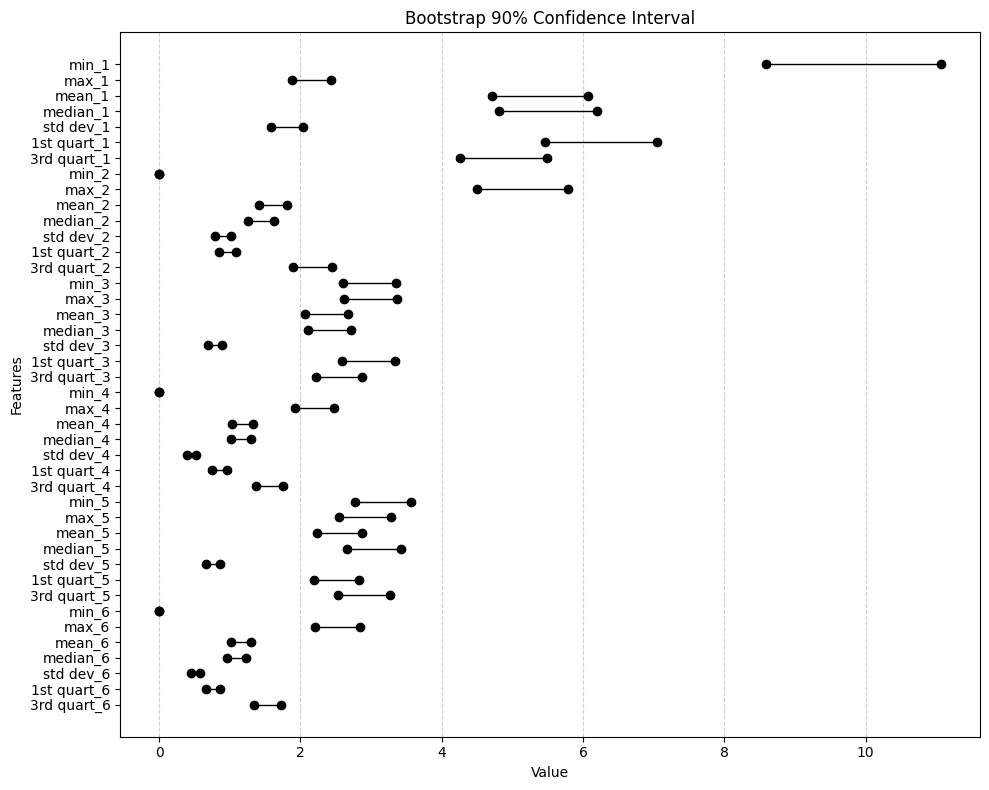

In [74]:
plt.figure(figsize=(10, 8))

# Plot the confidence intervals
plt.hlines(y=df_results['Feature'], xmin=df_results['CI Lower'], xmax=df_results['CI Upper'], color="black", linewidth=1)

# Plot circle markers at the CI limits
plt.plot(df_results['CI Lower'], df_results['Feature'], "o", color="black")
plt.plot(df_results['CI Upper'], df_results['Feature'], "o", color="black")

# Customize the plot
plt.xlabel('Value')
plt.ylabel('Features')
plt.title('Bootstrap 90% Confidence Interval')

# Invert the y-axis
plt.gca().invert_yaxis()

# Add grid lines
plt.grid(axis='x', linestyle='--', alpha=0.6)

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()

### iv) Use your judgement to select the three most important time-domain features (one option could be min, mean, and max)

The three most important time-domain features that I determined are mean, median, and standard deviation. 

The graph above shows that the feature standard deviation is a small value of the estimated values, even when other features have a large confidence interval or estimated value. Choosing mean and median would be more accurate for our future classification model. 

However, even the feature 'min' has a small value for the confidence intervals, such as the confidence interval of some min features is (0,0) and same with the estimated standard deviation of min. Our goal for the classification model is to include more flexibility thus, we choose not to pick feature min. 

### References 
scipy.stats.bootstrap 

Determining Features for Time Series Classification: https://stats.stackexchange.com/questions/50807/features-for-time-series-classification#:~:text=Usually%20the%20features%20used%20to,than%20being%20features%20in%20themselves.

Time Series classification based on statistical features: https://jwcn-eurasipjournals.springeropen.com/articles/10.1186/s13638-020-1661-4
